### ЧАСТЬ 2

In [1]:
import os
from pyspark.sql import SparkSession, DataFrame
from pyspark import SparkConf
from pyspark.sql.functions import (
    col, lit, sum, mean, when,
    explode, count, desc, floor,
    corr, array_contains, lit, first
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def create_spark_configuration() -> SparkConf:
    """
    Создает и конфигурирует экземпляр SparkConf для приложения Spark.

    Returns:
        SparkConf: Настроенный экземпляр SparkConf.
    """
    # Получаем имя пользователя
    user_name = os.getenv("USER")
    
    conf = SparkConf()
    conf.setAppName("lab 1 Test")
    conf.setMaster("yarn")
    conf.set("spark.submit.deployMode", "client")
    conf.set("spark.executor.memory", "12g")
    conf.set("spark.executor.cores", "8")
    conf.set("spark.executor.instances", "2")
    conf.set("spark.driver.memory", "4g")
    conf.set("spark.driver.cores", "2")
    conf.set("spark.jars.packages", "org.apache.iceberg:iceberg-spark-runtime-3.5_2.12:1.6.0")
    conf.set("spark.sql.extensions", "org.apache.iceberg.spark.extensions.IcebergSparkSessionExtensions")
    conf.set("spark.sql.catalog.spark_catalog", "org.apache.iceberg.spark.SparkCatalog")
    conf.set("spark.sql.catalog.spark_catalog.type", "hadoop")
    conf.set("spark.sql.catalog.spark_catalog.warehouse", f"hdfs:///user/{user_name}/warehouse")
    conf.set("spark.sql.catalog.spark_catalog.io-impl", "org.apache.iceberg.hadoop.HadoopFileIO")

    return conf

In [3]:
conf = create_spark_configuration()

In [4]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark

:: loading settings :: url = jar:file:/opt/spark-3.5.2-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/user0/.ivy2/cache
The jars for the packages stored in: /home/user0/.ivy2/jars
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c5456939-43e6-4a95-b53d-da38f7a9b348;1.0
	confs: [default]
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 in central
:: resolution report :: resolve 587ms :: artifacts dl 19ms
	:: modules in use:
	org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.6.0 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spa

Подключимся к созданной БД и табличке

In [5]:
database_name = "samorokov_db"

In [6]:
# Установим БД, как текущую
spark.catalog.setCurrentDatabase(database_name)

In [31]:
# Прочитаем таблчку из БД
df = spark.table("sobd_table_lab1")

In [9]:
# Выведем табличку на экран
df.show()

+---+-------+----------+-------+------+
|Ply|GamePly|HasCastled|   Eval|Result|
+---+-------+----------+-------+------+
|110|    157|         2|  305.0|   1.0|
| 29|    238|         3|  108.0|   0.5|
| 40|    231|         3|   46.0|   1.0|
| 44|    111|         3|  236.0|   1.0|
| 38|    165|         0|   37.0|   0.5|
| 54|    119|         3|  223.0|   0.5|
| 93|    129|         3|  450.0|   1.0|
| 43|    141|         3|  112.0|   1.0|
|100|    114|         3|-1894.0|   0.0|
| 80|    119|         2|  198.0|   0.5|
| 28|     46|         3|   -8.0|   0.0|
| 34|    197|         3|   -3.0|   1.0|
| 32|    110|         3|  -79.0|   0.0|
| 14|    103|         1|   59.0|   0.5|
| 24|     93|         3|  108.0|   1.0|
| 45|    112|         3|   63.0|   0.5|
| 38|     69|         3|   30.0|   1.0|
| 78|     92|         3|  215.0|   1.0|
| 73|    161|         3|  -23.0|   0.0|
| 64|     75|         3|  396.0|   1.0|
+---+-------+----------+-------+------+
only showing top 20 rows



In [10]:
# Посмотрим на схему данных 
df.printSchema()

root
 |-- Ply: integer (nullable = true)
 |-- GamePly: integer (nullable = true)
 |-- HasCastled: integer (nullable = true)
 |-- Eval: float (nullable = true)
 |-- Result: float (nullable = true)



In [32]:
# Посмотрим кол-во строчек 
df.count()

before_delete_dub = df.count()
print(f"Количество строчек равно: {before_delete_dub}")

Количество строчек равно: 109154250


In [33]:
# Удалим полностью дублирующиеся строки 
df = df.dropDuplicates()
after_delete_dub = df.count()

print(f" Количество удаленных дубликатов равно: {before_delete_dub - after_delete_dub}")
print(f"\n Количество строк после удаления равно: {after_delete_dub}")

 Количество удаленных дубликатов равно: 55509324

 Количество строк после удаления равно: 53644926


## Анализ колонок

Создадим функцию для подсчета пустых значений в колонках

In [ ]:
def count_nulls(data: DataFrame,
                column_name: str) -> None:
    """
    Подсчет количества null и not null значений в указанном столбце.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column_name (str): Имя столбца для подсчета null и not null значений.
    
    Returns:
        None
    """
    # Подсчет количества null значений в указанном столбце
    null_counts = data.select(
        sum(col(column_name).isNull().cast("int"))
    ).collect()[0][0]

    # Подсчет количества not null значений в указанном столбце
    not_null_counts = data.select(
        sum(col(column_name).isNotNull().cast("int"))
    ).collect()[0][0]

    # Вывод результатов
    print(f"Число колонок с NULL: {null_counts} "
          f"({100 * null_counts / (null_counts + not_null_counts):.2f}%)")

1. Анализ колонки Ply - Количество полуходов (ходов для белых и черных) в текущей игре. (Это количество ходов без взятия фигуры и движения пешек. Используется для правила 50 ходов, после которых может быть объявлена ничья.)

In [18]:
count_nulls(data=df, column_name="Ply")

Число колонок с NULL: 0 (0.00%)


In [25]:
# Проверим на наличие дубликатов (естественно они будут)
(
    df
    .groupBy("Ply")
    .count()
    .where("count > 1")
    .orderBy("count", ascending=False)
    .show()
)

+---+-------+
|Ply|  count|
+---+-------+
| 33|1212704|
| 34|1210706|
| 35|1210394|
| 32|1208462|
| 31|1207514|
| 36|1205642|
| 37|1202596|
| 38|1197057|
| 30|1196581|
| 39|1191135|
| 29|1189713|
| 40|1185353|
| 41|1179922|
| 42|1172632|
| 28|1168959|
| 43|1165338|
| 44|1158416|
| 27|1154346|
| 45|1151930|
| 46|1143608|
+---+-------+
only showing top 20 rows



In [26]:
# Выведем пример дубликатов (как видим, они не индентичны)
df.filter(col("Ply") == "33").show()

+---+-------+----------+------+------+
|Ply|GamePly|HasCastled|  Eval|Result|
+---+-------+----------+------+------+
| 33|     65|         3| 290.0|   1.0|
| 33|    154|         3|  -8.0|   0.0|
| 33|    132|         1|  31.0|   1.0|
| 33|    168|         0| -68.0|   0.0|
| 33|     77|         3|-160.0|   0.5|
| 33|    183|         3|  17.0|   1.0|
| 33|     86|         3| -15.0|   0.0|
| 33|     81|         3| 266.0|   1.0|
| 33|    141|         3| 120.0|   1.0|
| 33|     95|         0|  20.0|   1.0|
| 33|    116|         2| -17.0|   0.5|
| 33|     67|         3| -63.0|   0.5|
| 33|    123|         3|  54.0|   1.0|
| 33|    231|         1| -15.0|   0.5|
| 33|     67|         3|-133.0|   0.5|
| 33|    123|         3| 111.0|   1.0|
| 33|    141|         3| -91.0|   1.0|
| 33|    228|         3|  60.0|   0.5|
| 33|     68|         3| -36.0|   0.0|
| 33|    116|         1| 104.0|   0.5|
+---+-------+----------+------+------+
only showing top 20 rows



Минимальное значение:          11.00
Среднее значение:              92.67
Среднеквадратичное отклонение: 59.09
Первый квартиль:               49.00
Медиана:                       81.00
Третий квартиль:               122.00
Максимальное значение:         799.00


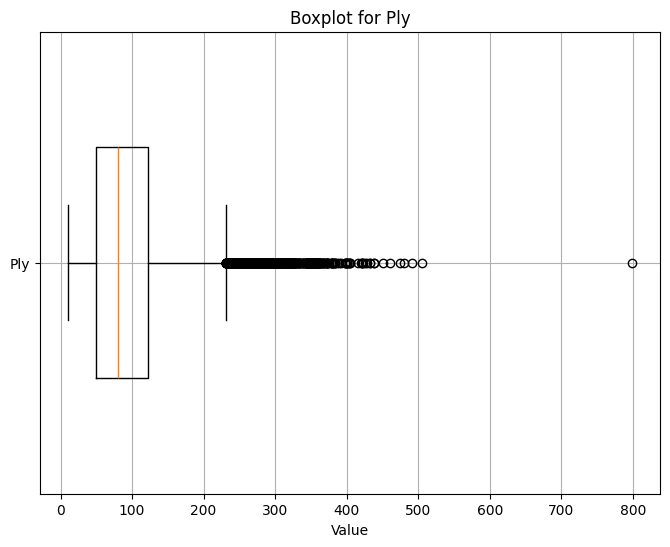

In [43]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

def plot_boxplots_for_ply(data: DataFrame, column: str, sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для одного столбца (например, Ply) в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    # Вычисление квантилей
    quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
    q1, median, q3 = quantiles

    # Вычисление IQR и границ усов
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Фильтрация выбросов
    filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

    # Вычисление минимального и максимального значений
    min_value = data.agg({column: "min"}).collect()[0][0]
    mean_value = data.agg({column: "mean"}).collect()[0][0]
    std_value = data.agg({column: "std"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Ограничение усов минимальным и максимальным значениями
    lower_bound = max(lower_bound, min_value)
    upper_bound = min(upper_bound, max_value)

    # Семплирование выбросов
    outliers = []
    if not outliers_df.isEmpty():
        sampled_outliers_df = outliers_df.sample(sample_fraction)
        outliers = (
            sampled_outliers_df
            .select(column)
            .limit(1000)
            .collect()
        )
        outliers = [row[column] for row in outliers]

        # Добавление минимального и максимального значений, если они
        # относятся к выбросам и не присутствуют в семпле
        if min_value < lower_bound and min_value not in outliers:
            outliers.append(min_value)
        if max_value > upper_bound and max_value not in outliers:
            outliers.append(max_value)

    # Подготовка данных для axes.bxp
    box_data = [{
        'whislo': lower_bound,  # Нижняя граница усов
        'q1': q1,               # Первый квартиль
        'med': median,          # Медиана
        'q3': q3,               # Третий квартиль
        'whishi': upper_bound,  # Верхняя граница усов
        'fliers': outliers      # Выбросы
    }]
    
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bxp(box_data, vert=False, positions=[1], widths=0.5)
    ax.set_yticks([1])
    ax.set_yticklabels([column])
    ax.set_xlabel('Value')
    ax.set_title(f'Boxplot for {column}')
    ax.grid(True)
    plt.show()

# Вызов функции с вашим датафреймом для столбца "Ply"
plot_boxplots_for_ply(data=df, column="Ply")


Отфильтруем данные, оставив только те значения, которые находятся в пределах допустимых границ (между нижней и верхней границей усов, как вычислено с помощью IQR).

In [53]:
from pyspark.sql.functions import col

def remove_outliers(data: DataFrame, column: str) -> DataFrame:
    """
    Убирает выбросы из столбца в DataFrame, используя IQR.
    
    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца, из которого нужно удалить выбросы.
    
    Returns:
        DataFrame: DataFrame без выбросов.
    """
    # Вычисление квантилей для столбца
    quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
    q1, median, q3 = quantiles
    
    # Вычисление IQR и границ усов
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Фильтрация выбросов
    filtered_data = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    
    return filtered_data

# Применяем функцию на данные для столбца "Ply"
df_filtered = remove_outliers(data=df, column="Ply")

# Выводим количество строк до и после удаления выбросов
print(f"Количество строк до удаления выбросов: {df.count()}")
print(f"Количество строк после удаления выбросов: {df_filtered.count()}")


Количество строк до удаления выбросов: 53644926


Количество строк после удаления выбросов: 51989818


2. Анализ колонки GamePly - Номер полного хода в игре (для белых и черных) (Это текущий номер хода, начиная с 1, где каждый полный ход включает два полушага — ход белых и ход черных.)

In [19]:
count_nulls(data=df, column_name="GamePly")

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          22.00
Среднее значение:              170.50
Среднеквадратичное отклонение: 74.60
Первый квартиль:               118.00
Медиана:                       156.00
Третий квартиль:               210.00
Максимальное значение:         810.00


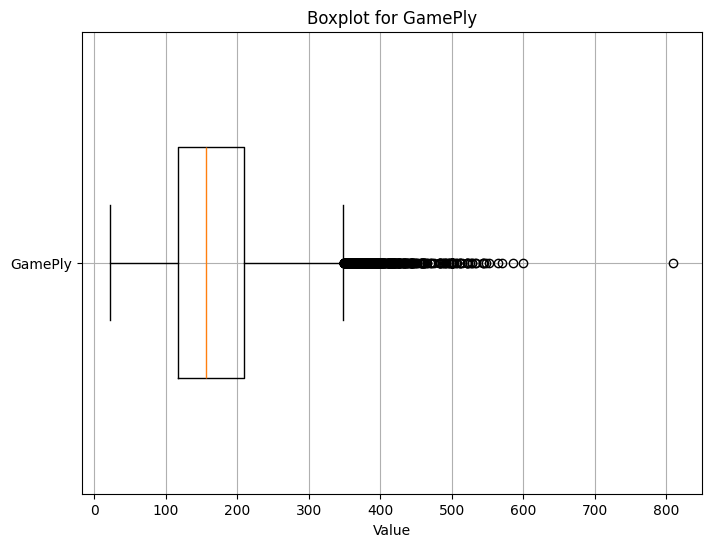

In [44]:
def plot_boxplots_for_game_ply(data: DataFrame, column: str, sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для одного столбца (например, GamePly) в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    # Вычисление квантилей
    quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
    q1, median, q3 = quantiles

    # Вычисление IQR и границ усов
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Фильтрация выбросов
    filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

    # Вычисление минимального и максимального значений
    min_value = data.agg({column: "min"}).collect()[0][0]
    mean_value = data.agg({column: "mean"}).collect()[0][0]
    std_value = data.agg({column: "std"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Ограничение усов минимальным и максимальным значениями
    lower_bound = max(lower_bound, min_value)
    upper_bound = min(upper_bound, max_value)

    # Семплирование выбросов
    outliers = []
    if not outliers_df.isEmpty():
        sampled_outliers_df = outliers_df.sample(sample_fraction)
        outliers = (
            sampled_outliers_df
            .select(column)
            .limit(1000)
            .collect()
        )
        outliers = [row[column] for row in outliers]

        # Добавление минимального и максимального значений, если они
        # относятся к выбросам и не присутствуют в семпле
        if min_value < lower_bound and min_value not in outliers:
            outliers.append(min_value)
        if max_value > upper_bound and max_value not in outliers:
            outliers.append(max_value)

    # Подготовка данных для axes.bxp
    box_data = [{
        'whislo': lower_bound,  # Нижняя граница усов
        'q1': q1,               # Первый квартиль
        'med': median,          # Медиана
        'q3': q3,               # Третий квартиль
        'whishi': upper_bound,  # Верхняя граница усов
        'fliers': outliers      # Выбросы
    }]
    
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bxp(box_data, vert=False, positions=[1], widths=0.5)
    ax.set_yticks([1])
    ax.set_yticklabels([column])
    ax.set_xlabel('Value')
    ax.set_title(f'Boxplot for {column}')
    ax.grid(True)
    plt.show()

# Вызов функции с вашим датафреймом для столбца "GamePly"
plot_boxplots_for_game_ply(data=df, column="GamePly")


Преобразование значений в столбце через логарифмирование может уменьшить влияние крупных выбросов. А далее удаление выбросов с использованием IQR (межквартильного размаха).

In [55]:
from pyspark.sql.functions import log, col

def log_transform_and_remove_outliers(data: DataFrame, column: str) -> DataFrame:
    """
    Применяет логарифмирование для преобразования значений и удаляет выбросы с использованием IQR.
    
    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца, для которого нужно применить логарифмирование и удалить выбросы.
    
    Returns:
        DataFrame: DataFrame после логарифмирования и удаления выбросов.
    """
    # Логарифмирование значений в столбце с использованием PySpark функции
    log_column = f"log_{column}"
    data = data.withColumn(log_column, log(col(column)))

    # Вычисление квантилей для логарифмированных значений
    quantiles = data.approxQuantile(log_column, [0.25, 0.5, 0.75], 0.01)
    q1, median, q3 = quantiles
    
    # Вычисление IQR и границ усов
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Фильтрация выбросов
    filtered_data = data.filter((col(log_column) >= lower_bound) & (col(log_column) <= upper_bound))
    
    # Возвращаем данные без выбросов и с логарифмированными значениями
    return filtered_data

# Применяем функцию на данные для столбца "GamePly"
df_filtered = log_transform_and_remove_outliers(data=df, column="GamePly")

# Выводим количество строк до и после удаления выбросов
print(f"Количество строк до удаления выбросов: {df.count()}")
print(f"Количество строк после удаления выбросов: {df_filtered.count()}")


Количество строк до удаления выбросов: 53644926


Количество строк после удаления выбросов: 53173028


3. Анализ колонки HasCastled - Показывает, было ли сделано рокирование в игре (0 - не было, 3 - было) (категориальный, все ост. - количественные)

In [20]:
count_nulls(data=df, column_name="HasCastled")

Число колонок с NULL: 0 (0.00%)


   HasCastled     count
0           0   4235033
1           1   8780438
2           2   6137160
3           3  34492295


/tmp/ipykernel_1558716/2462102440.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="HasCastled", y="count", data=categories_pd, palette="muted")


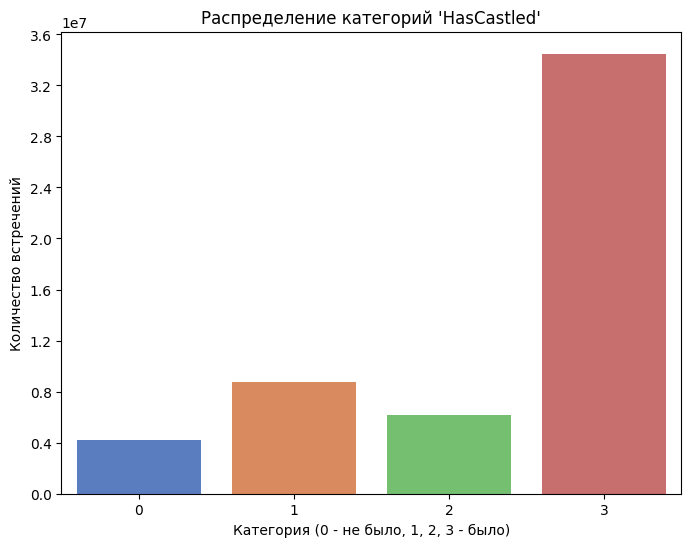

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

def plot_has_castled_distribution(data: DataFrame) -> None:
    """
    Построение распределения для столбца HasCastled.

    Args:
        data (DataFrame): DataFrame, содержащий данные.

    Returns:
        None
    """
    # Группировка данных по столбцу HasCastled и подсчет количества
    categories = (
        data
        .groupBy("HasCastled")
        .count()
        .orderBy("HasCastled")
    )

    # Проверка наличия данных
    if categories.count() == 0:
        print("Нет данных для отображения.")
        return

    # Преобразование в Pandas DataFrame
    categories_pd = categories.toPandas()

    # Проверка данных
    print(categories_pd)

    # Визуализация
    plt.figure(figsize=(8, 6))
    sns.barplot(x="HasCastled", y="count", data=categories_pd, palette="muted")

    # Настройка осей
    plt.title("Распределение категорий 'HasCastled'")
    plt.xlabel("Категория (0 - не было, 1, 2, 3 - было)")
    plt.ylabel("Количество встречений")
    plt.xticks(rotation=0)
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Целочисленные значения на оси Y

    # Отображение графика
    plt.show()

# Вызов функции с вашим датафреймом
plot_has_castled_distribution(data=df)


4. Анализ колонки Eval - Оценка текущей позиции в терминах силы (например, положительное значение для белых, отрицательное — для черных)

In [21]:
count_nulls(data=df, column_name="Eval")

Число колонок с NULL: 0 (0.00%)


Минимальное значение:          -7479.00
Среднее значение:              40.57
Среднеквадратичное отклонение: 539.52
Первый квартиль:               -111.00
Медиана:                       27.00
Третий квартиль:               178.00
Максимальное значение:         7427.00


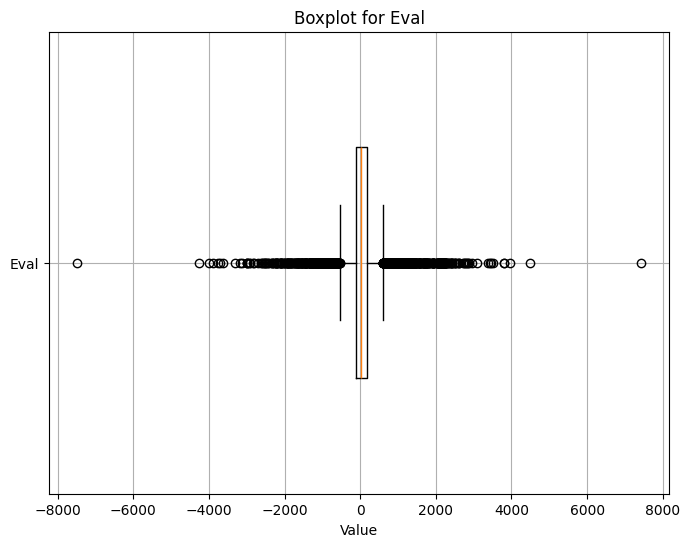

In [45]:
def plot_boxplots_for_eval(data: DataFrame, column: str, sample_fraction: float = 0.1) -> None:
    """
    Построение boxplot для одного столбца (например, Eval) в PySpark DataFrame.

    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца для построения boxplot.
        sample_fraction (float): Доля данных для семплирования выбросов.
    
    Returns:
        None
    """
    # Вычисление квантилей
    quantiles = data.approxQuantile(column, [0.25, 0.5, 0.75], 0.01)
    q1, median, q3 = quantiles

    # Вычисление IQR и границ усов
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Фильтрация выбросов
    filtered_df = data.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))
    outliers_df = data.filter((col(column) < lower_bound) | (col(column) > upper_bound))

    # Вычисление минимального и максимального значений
    min_value = data.agg({column: "min"}).collect()[0][0]
    mean_value = data.agg({column: "mean"}).collect()[0][0]
    std_value = data.agg({column: "std"}).collect()[0][0]
    max_value = data.agg({column: "max"}).collect()[0][0]

    # Ограничение усов минимальным и максимальным значениями
    lower_bound = max(lower_bound, min_value)
    upper_bound = min(upper_bound, max_value)

    # Семплирование выбросов
    outliers = []
    if not outliers_df.isEmpty():
        sampled_outliers_df = outliers_df.sample(sample_fraction)
        outliers = (
            sampled_outliers_df
            .select(column)
            .limit(1000)
            .collect()
        )
        outliers = [row[column] for row in outliers]

        # Добавление минимального и максимального значений, если они
        # относятся к выбросам и не присутствуют в семпле
        if min_value < lower_bound and min_value not in outliers:
            outliers.append(min_value)
        if max_value > upper_bound and max_value not in outliers:
            outliers.append(max_value)

    # Подготовка данных для axes.bxp
    box_data = [{
        'whislo': lower_bound,  # Нижняя граница усов
        'q1': q1,               # Первый квартиль
        'med': median,          # Медиана
        'q3': q3,               # Третий квартиль
        'whishi': upper_bound,  # Верхняя граница усов
        'fliers': outliers      # Выбросы
    }]
    
    # Вывод статистических характеристик
    print(f"Минимальное значение:          {min_value:.2f}")
    print(f"Среднее значение:              {mean_value:.2f}")
    print(f"Среднеквадратичное отклонение: {std_value:.2f}")
    print(f"Первый квартиль:               {q1:.2f}")
    print(f"Медиана:                       {median:.2f}")
    print(f"Третий квартиль:               {q3:.2f}")
    print(f"Максимальное значение:         {max_value:.2f}")

    # Построение boxplot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bxp(box_data, vert=False, positions=[1], widths=0.5)
    ax.set_yticks([1])
    ax.set_yticklabels([column])
    ax.set_xlabel('Value')
    ax.set_title(f'Boxplot for {column}')
    ax.grid(True)
    plt.show()

# Вызов функции с вашим датафреймом для столбца "Eval"
plot_boxplots_for_eval(data=df, column="Eval")


Преобразование значений в столбце через логарифмирование может уменьшить влияние крупных выбросов. А далее удаление выбросов с использованием IQR (межквартильного размаха).

In [56]:
from pyspark.sql.functions import log, col

def log_transform_and_remove_outliers_for_eval(data: DataFrame, column: str) -> DataFrame:
    """
    Применяет логарифмирование для преобразования значений и удаляет выбросы с использованием IQR.
    
    Args:
        data (DataFrame): DataFrame, содержащий данные.
        column (str): Имя столбца, для которого нужно применить логарифмирование и удалить выбросы.
    
    Returns:
        DataFrame: DataFrame после логарифмирования и удаления выбросов.
    """
    # Логарифмирование значений в столбце с использованием PySpark функции
    log_column = f"log_{column}"
    data = data.withColumn(log_column, log(col(column)))

    # Вычисление квантилей для логарифмированных значений
    quantiles = data.approxQuantile(log_column, [0.25, 0.5, 0.75], 0.01)
    q1, median, q3 = quantiles
    
    # Вычисление IQR и границ усов
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Фильтрация выбросов
    filtered_data = data.filter((col(log_column) >= lower_bound) & (col(log_column) <= upper_bound))
    
    # Возвращаем данные без выбросов и с логарифмированными значениями
    return filtered_data

# Применяем функцию на данные для столбца "Eval"
df_filtered_eval = log_transform_and_remove_outliers_for_eval(data=df, column="Eval")

# Выводим количество строк до и после удаления выбросов
print(f"Количество строк до удаления выбросов: {df.count()}")
print(f"Количество строк после удаления выбросов: {df_filtered_eval.count()}")


Количество строк до удаления выбросов: 53644926


Количество строк после удаления выбросов: 29311339


5. Анализ колонки Result - Результат игры (    0.0 — поражение для игрока, чей ход зафиксирован,
    0.5 — ничья,
    1.0 — победа для игрока, чей ход зафиксирован. (категориальный)

In [22]:
count_nulls(data=df, column_name="Result")

Число колонок с NULL: 0 (0.00%)


   Result     count
0     0.0  15265825
1     0.5  20431319
2     1.0  17947782


/tmp/ipykernel_1558716/3902654487.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Result", y="count", data=categories_pd, palette="muted")


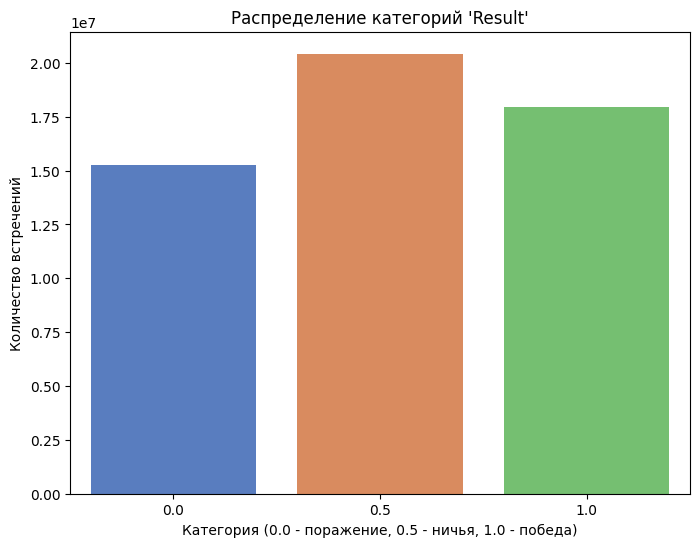

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

def plot_result_distribution(data: DataFrame) -> None:
    """
    Построение распределения для столбца Result.

    Args:
        data (DataFrame): DataFrame, содержащий данные.

    Returns:
        None
    """
    # Группировка данных по столбцу Result и подсчет количества
    categories = (
        data
        .groupBy("Result")
        .count()
        .orderBy("Result")
    )

    # Проверка наличия данных
    if categories.count() == 0:
        print("Нет данных для отображения.")
        return

    # Преобразование в Pandas DataFrame
    categories_pd = categories.toPandas()

    # Проверка данных
    print(categories_pd)

    # Визуализация
    plt.figure(figsize=(8, 6))
    sns.barplot(x="Result", y="count", data=categories_pd, palette="muted")

    # Настройка осей
    plt.title("Распределение категорий 'Result'")
    plt.xlabel("Категория (0.0 - поражение, 0.5 - ничья, 1.0 - победа)")
    plt.ylabel("Количество встречений")
    plt.xticks(rotation=0)
    plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))  # Целочисленные значения на оси Y

    # Отображение графика
    plt.show()

# Вызов функции с вашим датафреймом
plot_result_distribution(data=df)


## Корреляции между количественными признаками

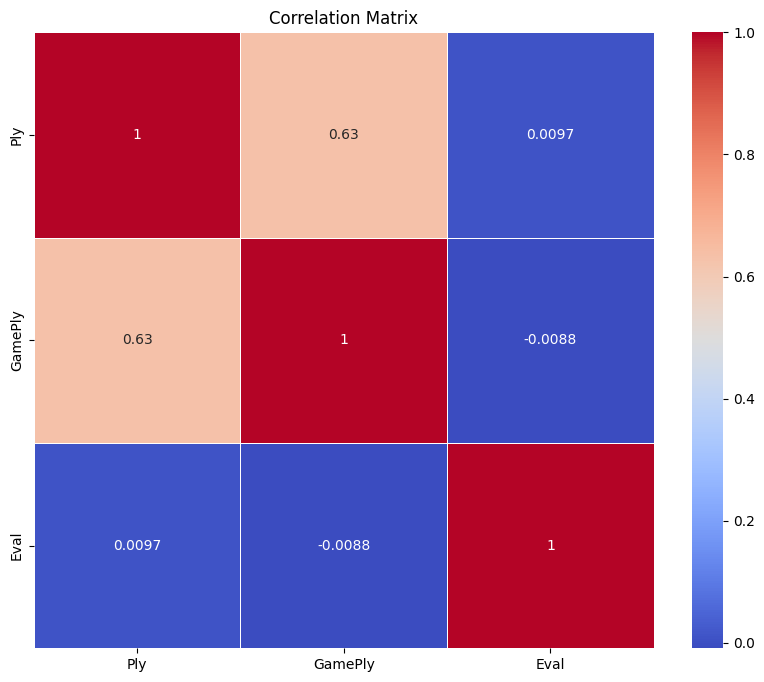

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import corr
import pandas as pd

def compute_and_visualize_correlation_matrix(data: DataFrame, 
                                             columns: list[str]) -> None:
    """
    Вычисляет и визуализирует корреляционную матрицу для указанных 
    колонок в DataFrame PySpark.

    Args:
        data (DataFrame): DataFrame PySpark.
        columns (list[str]): Список колонок для вычисления корреляции.

    Returns:
        None
    """
    # Вычисление корреляционной матрицы
    corr_matrix = {}
    for col1 in columns:
        corr_matrix[col1] = {}
        for col2 in columns:
            corr_value = data.select(corr(col1, col2)).collect()[0][0]
            corr_matrix[col1][col2] = corr_value

    # Преобразование корреляционной матрицы в DataFrame Pandas для визуализации
    corr_matrix_pd = pd.DataFrame(corr_matrix)

    # Построение и визуализация корреляционной матрицы
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_pd, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.show()

# Вызов функции с вашими столбцами
compute_and_visualize_correlation_matrix(
    data=df, columns=["Ply", "GamePly", "Eval"]
)


-- Ply: Целое число. От 0 и выше (обычно от 0 до 100, в зависимости от хода). 
    Количество полуходов (ходов для белых и черных) в текущей игре. Это число увеличивается на 1 с каждым ходом.

-- GamePly: Целое число. От 1 и выше (обычно от 1 до 200 и более). 
    Номер полного хода в игре (для белых и черных). Например, если в игре было сделано 10 полных ходов, то GamePly будет 10.

-- Eval: Число с плавающей точкой. От -∞ до +∞.
    Оценка текущей позиции в терминах силы (например, положительное значение для белых, отрицательное — для черных).

In [49]:
df.count()

53644926

In [50]:
df.printSchema()

root
 |-- Ply: integer (nullable = true)
 |-- GamePly: integer (nullable = true)
 |-- HasCastled: integer (nullable = true)
 |-- Eval: float (nullable = true)
 |-- Result: float (nullable = true)



Сохраним очищенную и обработанную таблицу на диск

In [51]:
# Сохранение DataFrame в виде таблицы
df.writeTo("sobd_table_lab2").using("iceberg").create()

In [52]:
for table in spark.catalog.listTables():
    print(table.name)

sobd_table_lab1
sobd_table_lab2


ПРИМЕР (удаления таблицы):
##### spark.sql("DROP TABLE spark_catalog.ivanov_database.sobd_lab1_table")
##### spark.sql("DROP DATABASE spark_catalog.ivanov_database")

In [ ]:
# После удачной записи остановим сессию
spark.stop()